# TODOs
- [x] reduce decoder linear layers
- [x] remove pe for debug
- [ ] remove dimension numbers
- [x] use xyz only
- checkpoint
- mse [ephoch arr]
- cc [ephoch arr]
- 

In [1]:
# %load_ext autoreload
# %autoreload 2
# from utils import *
# from Network import *
# basic packages
import numpy as np
import glob
import math
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io
from scipy import stats
import os
import copy
import time
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision.transforms import ToTensor
#from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm
import sys
# sys.path.append('/scratch/xc1490/projects/tmp/python_packages')
import wandb
wandb.__version__
%pylab inline

/tmp/ipykernel_2463323/4186659708.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/ext3/miniconda3/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
# config
PROJECT_PATH = os.path.dirname(os.getcwd())
FRAME_RATE = 60 # 60 frames/sec
MAX_HISTORY_TIME = 10
MAX_PREDICTION_TIME = 10
HISTORY_TIME = 2
PREDICTION_TIME = 2
HISTORY_LENGTH = HISTORY_TIME*FRAME_RATE
PREDICTION_LENGTH = PREDICTION_TIME*FRAME_RATE
MAX_HISTORY_LENGTH = MAX_HISTORY_TIME*FRAME_RATE
MAX_PREDICTION_LENGTH = MAX_PREDICTION_TIME*FRAME_RATE
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("device: ", DEVICE)
TOTAL_FEATURE_NAMES = ['head_x','head_y','head_z','head_r_sin','head_r_cos','head_p_sin','head_p_cos','head_y_sin',\
'head_y_cos','head_rx','head_ry','head_rz']
DEFAULT_FEATURE_NAMES = ['head_x','head_y','head_z','head_r_sin','head_r_cos','head_p_sin','head_p_cos','head_y_sin',\
'head_y_cos']
XYZ_FEATURE_NAMES = ['head_x', 'head_y', 'head_z']
ONE_FEATURE = ['head_x']
SC_FEATURE_NAMES = ['head_r_sin','head_r_cos','head_p_sin','head_p_cos','head_y_sin','head_y_cos']
RPY_FEATURE_NAMES = ['head_rx','head_ry','head_rz']
ANGLE_FEATURE_NAMES = ['head_r_cos','head_p_sin','head_p_cos','head_y_sin','head_y_cos','head_rx','head_ry','head_rz']
FEATURE_NAMES = ONE_FEATURE
FEATURE_INDEX = [TOTAL_FEATURE_NAMES.index(x) for x in FEATURE_NAMES]
DEFAULT_FEATURE_SIZE = len(DEFAULT_FEATURE_NAMES)
FEATURE_SIZE = len(FEATURE_NAMES)
BATCH_SIZE = 16

device:  cpu


In [3]:
class FoVDataset(Dataset):
    def __init__(self, x_data, y_data, feature_idx):
        self.feature_idx = feature_idx
        self.x_data = x_data[:,:,feature_idx]
        self.y_data = y_data[:,:,feature_idx]

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = torch.tensor(self.x_data[idx])
        y = torch.tensor(self.y_data[idx])
        return x,y

In [7]:
# load data
processed_data_path = f'{PROJECT_PATH}/processed_data'
x_train = np.loadtxt(f'{processed_data_path}/x_train_{HISTORY_TIME}_{PREDICTION_TIME}.csv', dtype='float32', delimiter=',').reshape((-1,HISTORY_LENGTH,DEFAULT_FEATURE_SIZE))
y_train = np.loadtxt(f'{processed_data_path}/y_train_{HISTORY_TIME}_{PREDICTION_TIME}.csv', dtype='float32', delimiter=',').reshape((-1,PREDICTION_LENGTH,DEFAULT_FEATURE_SIZE))
x_val = np.loadtxt(f'{processed_data_path}/x_val_{HISTORY_TIME}_{PREDICTION_TIME}.csv', dtype='float32', delimiter=',').reshape((-1,HISTORY_LENGTH,DEFAULT_FEATURE_SIZE))
y_val = np.loadtxt(f'{processed_data_path}/y_val_{HISTORY_TIME}_{PREDICTION_TIME}.csv', dtype='float32', delimiter=',').reshape((-1,PREDICTION_LENGTH,DEFAULT_FEATURE_SIZE))
x_test = np.loadtxt(f'{processed_data_path}/x_test_{HISTORY_TIME}_{PREDICTION_TIME}.csv', dtype='float32', delimiter=',').reshape((-1,HISTORY_LENGTH,DEFAULT_FEATURE_SIZE))
y_test = np.loadtxt(f'{processed_data_path}/y_test_{HISTORY_TIME}_{PREDICTION_TIME}.csv', dtype='float32', delimiter=',').reshape((-1,PREDICTION_LENGTH,DEFAULT_FEATURE_SIZE))
mean_std = np.loadtxt(f'{processed_data_path}/xyz_mean_std_{HISTORY_TIME}_{PREDICTION_TIME}.csv', dtype='float32', delimiter=',').reshape((3, -1))

1
(15360, 9)


<Figure size 640x480 with 0 Axes>

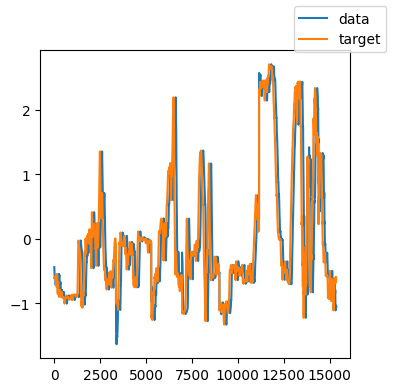

: 

In [12]:
# visualize val dataset
feature_size = FEATURE_SIZE
print(feature_size)
x_data = x_val[::8,:,:].reshape(-1,9)
print(x_data.shape)
y_data = y_val[::8,:,:].reshape(-1,9)
plt.figure()
if feature_size<=3:
    fig, ax = plt.subplots(1, feature_size, figsize=(feature_size*4,4))
    ax = [ax] if feature_size==1 else ax
    for i in range(feature_size):
        ax[i].plot(x_data[:,i])
        ax[i].plot(y_data[:,i])
else:
    rows = (feature_size-1)//3+1
    fig, ax = plt.subplots(rows, 3, figsize=(12,4*rows))
    for i in range(rows):
        for j in range(3):
            if i*3+j<feature_size:
                ax[i][j].plot(x_data[:,3*i+j])
                ax[i][j].plot(y_data[:,3*i+j])
fig.legend(["data","target"])
plt.show()

In [ ]:
# create dataset and dataloader
feature_names = FEATURE_NAMES
feature_idx = FEATURE_INDEX
x_train = x_train[:,:,feature_idx]
y_train = y_train[:,:,feature_idx]
x_val = x_val[:,:,feature_idx]
y_val = y_val[:,:,feature_idx]
x_test = x_test[:,:,feature_idx]
y_test = y_test[:,:,feature_idx]
train_data = FoVDataset(x_train, y_train, feature_idx)
val_data = FoVDataset(x_val, y_val, feature_idx)
test_data = FoVDataset(x_test, y_test, feature_idx)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
def visualize_data(data, target, prediction=None):
    batch_size, seq_len, feature_size = data.shape
    rand_batch =random.randint(batch_size)
    rand_data = data[rand_batch]
    rand_target = target[rand_batch]
    if prediction is not None:
        rand_pred = prediction[rand_batch]
    x = np.arange(seq_len)
    plt.figure()
    if feature_size<=3:
        fig, ax = plt.subplots(1, feature_size, figsize=(feature_size*4,4))
        for i in range(feature_size):
            ax[i].plot(rand_data[:,i])
            ax[i].plot(x+seq_len, rand_target[:,i])
            if prediction is not None:
                ax[i].plot(x+seq_len, rand_pred[:,i])
    else:
        rows = (feature_size-1)//3+1
        fig, ax = plt.subplots(rows, 3, figsize=(12,4*rows))
        for i in range(rows):
            for j in range(3):
                if i*3+j<feature_size:
                    ax[i][j].plot(rand_data[:,3*i+j])
                    ax[i][j].plot(x+seq_len, rand_target[:,3*i+j])
                    if prediction is not None:
                        ax[i][j].plot(x+seq_len,rand_pred[:,3*i+j])
    if prediction is None:
        fig.legend(["data","target"])
    else:
        fig.legend(["data","target","pred"])
    plt.show()

<Figure size 640x480 with 0 Axes>

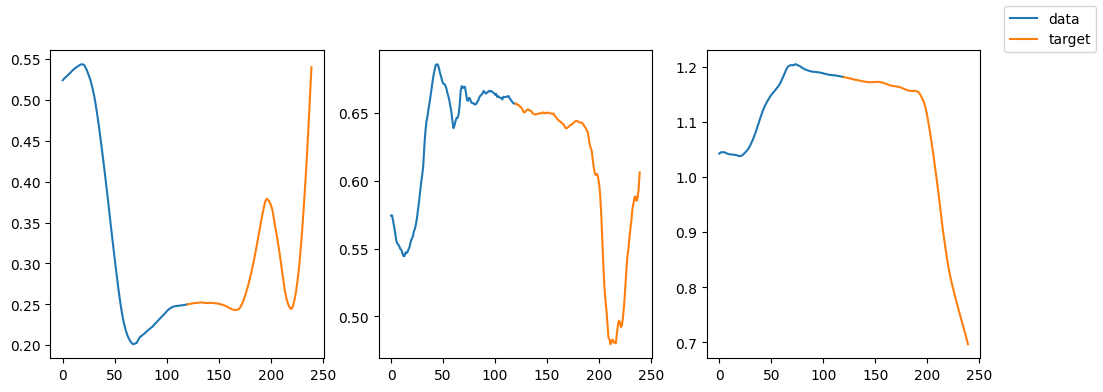

In [ ]:
visualize_data(x_train,y_train)

In [9]:
# checkpointing
def save_ckpt(path, model, optimizer, save_dict):
    
    path = f'{path}/batch_{BATCH_SIZE}_{HISTORY_TIME}to{PREDICTION_TIME}_ckpts.pt'
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            **save_dict
            }, path)

def load_ckpt(path, model, optimizer, device='cuda'):
    if device == 'cpu':
        checkpoint = torch.load(path,map_location=torch.device('cpu'))
    else:
        checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    del checkpoint['model_state_dict']
    del checkpoint['optimizer_state_dict']
    model.eval()
    return model, optimizer, checkpoint

In [10]:
def a_norm(Q, K, mask = None):
    m = torch.matmul(Q, K.transpose(2,1).float())
    m /= torch.sqrt(torch.tensor(Q.shape[-1]).float())
    
    
    if mask is not None:
        m.masked_fill(mask == 0, float("-1e20"))
    
    return torch.softmax(m , -1) #(batch_size, seq_length, seq_length)

def attention(Q, K, V, mask = None):
    #Attention(Q, K, V) = norm(QK)V
    a = a_norm(Q, K, mask) #(batch_size, seq_length, seq_length)
    
    return  torch.matmul(a,  V) #(batch_size, seq_length, head_dim)

class AttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, head_dim):
        super(AttentionBlock, self).__init__()
        self.value = nn.Linear(dim_val, head_dim, bias=True)
        self.key = nn.Linear(dim_val, head_dim, bias=True)
        self.query = nn.Linear(dim_val, head_dim, bias=True)
    
    def forward(self, x, kv = None, mask = None):
        if(kv is None):
            #Attention with x connected to Q,K and V (For encoder)
            output =  attention(self.query(x), self.key(x), self.value(x), mask)
        else:
            #Attention with x as Q, external vector kv as K an V (For decoder)
            output = attention(self.query(x), self.key(kv), self.value(kv), mask)

        
        return output #(batch_size, seq_length, head_dim)
    
class MultiHeadAttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, head_dim, n_heads):
        super(MultiHeadAttentionBlock, self).__init__()
        self.heads = []
        for i in range(n_heads):
            self.heads.append(AttentionBlock(dim_val, head_dim))
        self.heads = nn.ModuleList(self.heads)
        self.fc = nn.Linear(n_heads * head_dim, dim_val)
                      
    def forward(self, x, kv = None, mask = None):
        a = []
        for h in self.heads:
            a.append(h(x, kv = kv, mask = mask)) # [[N, seq_len, head_dim]_1,...,[]_heads]
            
        a = torch.stack(a, dim = -1) #combine heads
        a = a.flatten(start_dim = 2) #flatten all head outputs [N, seq_len, dim_val]
        x = self.fc(a)
        
        return x

# https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=600, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/ d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term[:pe[:,1::2].shape[1]])
        
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        self.register_buffer('pe', pe) # [seq_len, dim_val]
        
    def forward(self, x):
        x = x + self.pe[:x.size(1), :].squeeze(1) # x + [seq_len, dim_val]
        return x  

#TODO
class RelativePositionalEncoding(nn.Module):
    def __init__(self, seq_len, outout=0.1, max_len=5000):
        super(RelativePositionalEncoding, self).__init__()
        self.seq_len = seq_len
        self.table = nn.Linear(seq_len, 2*seq_len)
        

    def forward(self, x):
        x = table(x)
        return x 
class EncoderLayer(torch.nn.Module):
    def __init__(self, dim_val, head_dim, n_heads = 1, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.attn = MultiHeadAttentionBlock(dim_val, head_dim , n_heads)
        #self.attn = MultiHeadAttention(dim_val,head_dim ,  n_heads)
        self.fc1 = nn.Linear(dim_val, dim_val)
        self.fc2 = nn.Linear(dim_val, dim_val)
        self.norm1 = nn.LayerNorm(dim_val)
        self.norm2 = nn.LayerNorm(dim_val)
        # added a dropout layer
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask = None):
        # x: [N, enc_seq_len, dim_val]
        a = self.attn(x, mask)
        x1 = self.norm1(x + a)
        # does not have an forward expansion factor here! But maybe not a bad thing since we want smaller embedding size
        a1 = self.fc1(F.elu(self.fc2(x1)))
        out = self.norm2(x1 + a1) # [N, enc_seq_len, dim_val]
#         out = self.dropout(self.norm2(x1 + a1))
        #import pdb;pdb.set_trace()
        return out

class DecoderLayer(torch.nn.Module):
    def __init__(self, dim_val, head_dim, n_heads = 1, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.attn1 = MultiHeadAttentionBlock(dim_val, head_dim, n_heads)
        self.attn2 = MultiHeadAttentionBlock(dim_val, head_dim, n_heads)
        self.fc1 = nn.Linear(dim_val, dim_val)
        self.fc2 = nn.Linear(dim_val, dim_val)
        self.norm1 = nn.LayerNorm(dim_val)
        self.norm2 = nn.LayerNorm(dim_val)
        self.norm3 = nn.LayerNorm(dim_val)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc, mask):
        # x: [N, dec_seq_len, dim_val]
        a = self.attn1(x, kv=None, mask = mask)
        x = self.norm1(a + x)
        a = self.attn2(x, kv = enc, mask = mask) # TODO check does this need mask?
        x = self.norm2(a + x)
        a = self.fc1(F.elu(self.fc2(x)))
        x = self.norm3(x + a) # x: [N, dec_seq_len, dim_val]
        return x

class Transformer(torch.nn.Module):
    def __init__(self, n_heads, head_dim, feature_size, in_seq_len, out_seq_len, n_encoder_layers = 1, \
                 n_decoder_layers = 1, pe_mode = 'standard', device='cuda'):
        """
            dim_val: d_model - 64
            head_dim: 16
            feature_size: input feature size - 9(all)/3(xyz)/6(angles)
            in_seq_len: length of decoder input sequence - 600
            out_seq_len: decoder output sequence length - 1 or 600?
            pe_mode: positional encoding mode - 'relative' or 'standard' or 'none'
        """
        super(Transformer, self).__init__()
        dim_val = n_heads*head_dim
        self.device=device
        self.in_seq_len = in_seq_len
        self.out_seq_len = out_seq_len
        self.pe_mode = pe_mode
        self.n_heads = n_heads
        self.head_dim = head_dim
        self.dim_val = dim_val
        #Initiate encoder and Decoder layers
        self.encs = nn.ModuleList()
        for i in range(n_encoder_layers):
            self.encs.append(EncoderLayer(dim_val, head_dim, n_heads))
        
#         self.decs = nn.ModuleList()
#         for i in range(n_decoder_layers):
#             self.decs.append(DecoderLayer(dim_val, head_dim, n_heads))
        
        if pe_mode == 'standard':
            self.pos = PositionalEncoding(dim_val)
        #Dense layers for managing network inputs and outputs
#         self.enc_input_fc = nn.Linear(feature_size, dim_val)
#         self.enc_input_fc = nn.Sequential(
#             nn.Linear(feature_size, dim_val//2),
#             nn.LeakyReLU(),
#             nn.Linear(dim_val//2, dim_val),
#         )
        self.enc_input_fc = nn.Linear(feature_size, dim_val)
        self.dec_input_fc = nn.Linear(feature_size, dim_val)
#         self.enc_input_fc = nn.Conv1d(feature_size, dim_val,1)
#         self.dec_input_fc = nn.Conv1d(feature_size, dim_val,1)
#         self.out_fc = nn.Linear(dec_seq_len * dim_val, out_seq_len)
#         self.out_fc = nn.Sequential(
#             nn.Linear(dim_val, int(dim_val/2)),
#             nn.LeakyReLU(),
#             nn.Linear(int(dim_val/2), feature_size),
#         )
        self.out_fc = nn.Linear(dim_val, feature_size)
        self.final_activation = F.elu
        
    def make_trg_mask(self, N, trg_len):
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
           N, 1, trg_len, trg_len
        )
        return trg_mask.to(self.device)
    
    def forward(self, x, target=None):
        # x: [N, enc_seq_len, feature_size] = [N, 120, 3]
        # dec_input = [N, dec_seq_len, feature_size]
        
        # MLP
        mlp = self.enc_input_fc(x) # [N, enc_seq_len, dim_val]
        #encoder
        #print ('mlp',mlp)
#         mlp = x
        if self.pe_mode=='stardard':
            e = self.encs[0](self.pos(mlp))
            #print ('pe',  e)
        else:
            e = self.encs[0]( mlp )
            #print ('no pe',e)
        for enc in self.encs[1:]:
            e = enc(e) # [N, enc_seq_len, dim_val]
        #print ('e',e)
#         out = e
        #decoder
        out = self.out_fc(e) # [N, enc_seq_len, feature_size]
        #print ('out',out)
        #out = self.final_activation(out)
        #import pdb;pdb.set_trace()
        return out


In [11]:
#training hyperparams
in_seq_len = HISTORY_LENGTH
out_seq_len = PREDICTION_LENGTH

n_heads = 3 ##4
head_dim = 3 #32 # dimension of each head, not total
dim_val = 9 #16#n_heads*head_dim # embedding dimension, all heads together
feature_size = FEATURE_SIZE
lr = 0.005
tf_rate = 0.5
epochs = 200
n_decoder_layers = 2
n_encoder_layers = 2
batch_size = BATCH_SIZE
n_batches = len(train_dataloader)


#init network and optimizer
model = Transformer(n_heads, head_dim, feature_size, in_seq_len, out_seq_len, n_encoder_layers, n_decoder_layers, pe_mode = 'standard', device=DEVICE).to(device=DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
#keep track of loss for graph
train_mse_losses = []
val_mse_losses = []
test_mse_losses = []
sep_train_mse_losses = []
sep_val_mse_losses = []
sep_test_mse_losses = []
train_pearsonr_arr = []
val_pearsonr_arr = []
test_pearsonr_arr = []

NameError: name 'train_dataloader' is not defined

In [12]:
model(torch.rand(16,120,3).cuda()).shape

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [13]:
def my_loss(output, target, feature_names):
    # compute loss for each feature
    # output/target: [N, seq_len, 9]
    # change sin cos back to angle ?
    if 'head_r_sin' in feature_names:
        feature_idx = feature_names.index('head_r_sin')
        output_rx = torch.atan2(output[:,:,feature_idx], output[:,:,feature_idx+1]).unsqueeze(2)
        target_rx = torch.atan2(target[:,:,feature_idx], target[:,:,feature_idx+1]).unsqueeze(2)
        output = torch.cat((output,output_rx),-1)
    if 'head_p_sin' in feature_names:
        feature_idx = feature_names.index('head_p_sin')
        output_ry = torch.atan2(output[:,:,feature_idx], output[:,:,feature_idx+1]).unsqueeze(2)
        target_ry = torch.atan2(target[:,:,feature_idx], target[:,:,feature_idx+1]).unsqueeze(2)
        output = torch.cat((output,output_ry),-1)
    if 'head_y_sin' in feature_names:
        feature_idx = feature_names.index('head_y_sin')
        output_rz = torch.atan2(output[:,:,feature_idx], output[:,:,feature_idx+1]).unsqueeze(2)
        target_rz = torch.atan2(target[:,:,feature_idx], target[:,:,feature_idx+1]).unsqueeze(2)
        output = torch.cat((output,output_rz),-1)
        
    
    mse_loss = torch.mean((output - target) ** 2, [0,1])
    pearsonr = stats.pearsonr(output.detach().cpu().flatten(), target.detach().cpu().flatten())
    return mse_loss, pearsonr

In [14]:
def train(device, model: nn.Module, data_loader, optimizer, step, feature_names, plot_flag = False):
    progress_bar = tqdm(data_loader)
    model.train() # turn on train mode
    feature_size = len(feature_names)
    num_batches = len(data_loader)
    log_interval = num_batches // 5
    loss_names = list(map(lambda x: x+'_loss', feature_names))
    start_time = time.time()
    total_loss = 0.
    return_loss = 0.
    sep_return_loss = np.zeros((1,feature_size))
    loss_dict_train = {}
    for batch_idx, (data, targets) in enumerate(progress_bar):
#         print("batch index: ", batch_idx)
        data = data.to(device)
        targets = targets.to(device)
        # with torch.cuda.amp.autocast():
        output = model(data)
        optimizer.zero_grad()
        sep_mse_loss, train_pearsonr = my_loss(output, targets, feature_names)
        loss = torch.sum(sep_mse_loss[:feature_size])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        step += 1
        total_loss += loss.item()
        return_loss += loss.item()
        sep_return_loss += sep_mse_loss.detach().cpu().numpy()
        progress_bar.set_postfix_str(f"training loss={loss.item():.4e}|avg training loss={total_loss/(batch_idx+1):.4e}")
        loss_dict_train['training loss'] = loss.item()
        for name_count, loss_name in enumerate(loss_names):
            loss_dict_train[loss_name] = sep_mse_loss[name_count]
        loss_dict_train['avg training loss'] = total_loss/(batch_idx+1)
        loss_dict_train['train pearsonr'] = train_pearsonr
        
        if use_wandb:
            wandb.log(loss_dict_train) 
        if batch_idx % log_interval == 0 and batch_idx > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            print(f'| epoch {epoch:3d} | {batch_idx:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.5f} | ms/batch {ms_per_batch:5.5f} | '
                  f'loss {cur_loss:5.5f}')
            total_loss = 0
            start_time = time.time()
            if plot_flag == True:
                # training prediction
                print ('training prediction')
                visualize_data(data.detach().cpu().numpy(), targets.detach().cpu().numpy(), output.detach().cpu().numpy())
    return return_loss/(batch_idx+1), sep_return_loss/(batch_idx+1), train_pearsonr

def validate(device, model: nn.Module, dataloader: DataLoader, feature_names, plot_flag = False):
    feature_size = len(feature_names)
    loss_names = list(map(lambda x: x+'_loss', feature_names))
    model.eval()
    total_loss = 0.
    sep_total_loss = np.zeros((1,feature_size))
    loss_dict_valid = {}
    iter_count = 0
    with torch.no_grad():
        for (data, targets) in dataloader:
            data = data.to(device) # [N, seq_len, feature_size]
            targets = targets.to(device) # [N, seq_len, feature_size]
            output = model(data)
            if plot_flag and iter_count == 0:
                print ('validation prediction')
                visualize_data(data.detach().cpu().numpy(), targets.detach().cpu().numpy(), output.detach().cpu().numpy())
                if use_wandb:
                    wandb.log({"validation plot": fig})
            sep_valid_loss, valid_pearsonr = my_loss(output, targets, feature_names)
            total_loss += torch.sum(sep_valid_loss)
            sep_total_loss += sep_valid_loss.detach().cpu().numpy()
            #import pdb;pdb.set_trace()
            for name_count, loss_name in enumerate(loss_names):
                loss_dict_valid[loss_name] = sep_valid_loss[name_count]
            #loss_dict_valid['valid loss'] = sep_valid_loss
            loss_dict_valid['valid pearsonr'] = valid_pearsonr[0]
            iter_count += 1
            if use_wandb:
                wandb.log(loss_dict_valid) 
    return total_loss/(len(dataloader) - 1), sep_total_loss/(len(dataloader) - 1), valid_pearsonr
    

# def inference(model: nn.Module, dataloader: DataLoader) -> float:
#     model.eval()  # turn on evaluation mode
#     total_loss = 0.
#     o = []
#     loss_dict_test = {}
#     with torch.no_grad():
#         for (data, targets) in dataloader:
#             data = data.to(device=DEVICE) # [N, seq_len, feature_size]
#             targets = targets.to(device=DEVICE) # [N, seq_len, feature_size]
#             N, seq_len, feature_size = targets.shape
#             dec_input = torch.zeros(targets.shape)
#             for i in range(seq_len):
#                 if i == 0:
#                     dec_input = data
#                     output = model(data, dec_input)
#                     o = output
#                 else:
#                     dec_input[:,:seq_len-i,:] = data[:,i:,:]
#                     dec_input[:,seq_len-i:,:] = o
#                     output = model(data, dec_input)
#                     o = torch.hstack(o, output[:,-1,:])
#             test_loss = my_loss(o, targets).item()
#             total_loss += test_loss
#             loss_dict_test['test loss'] = test_loss
#             wandb.log(loss_dict_test) 
#             # print("val loss: ", total_loss)
#             # data = data.permute(1, 0, 2) #.detach().cpu().numpy()
#             # output = output.permute(1, 0, 2) #.detach().cpu().numpy()
#             # print("output2: ", output[0][0])
#     return total_loss / (len(dataloader) - 1)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch #1


  0%|          | 0/373 [00:00<?, ?it/s]

| epoch   1 |    74/  373 batches | lr 0.00500 | ms/batch 1332.58728 | loss 1.32212
training prediction


<Figure size 640x480 with 0 Axes>

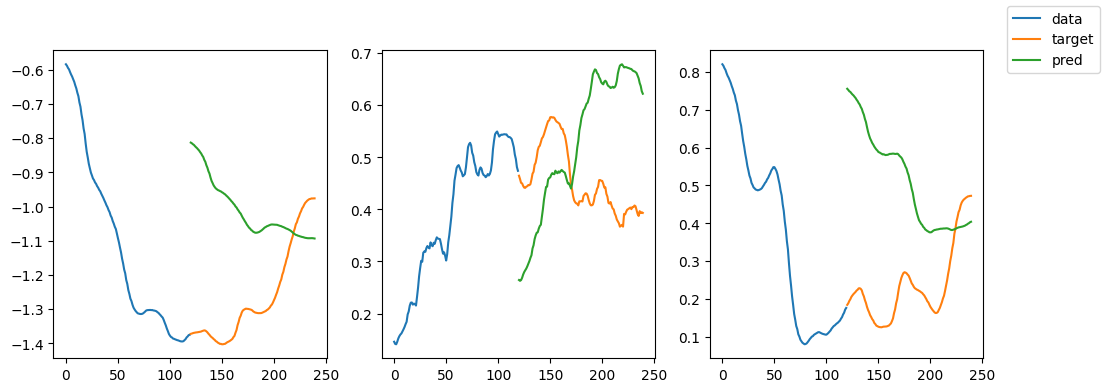

| epoch   1 |   148/  373 batches | lr 0.00500 | ms/batch 1310.79713 | loss 0.77055
training prediction


<Figure size 640x480 with 0 Axes>

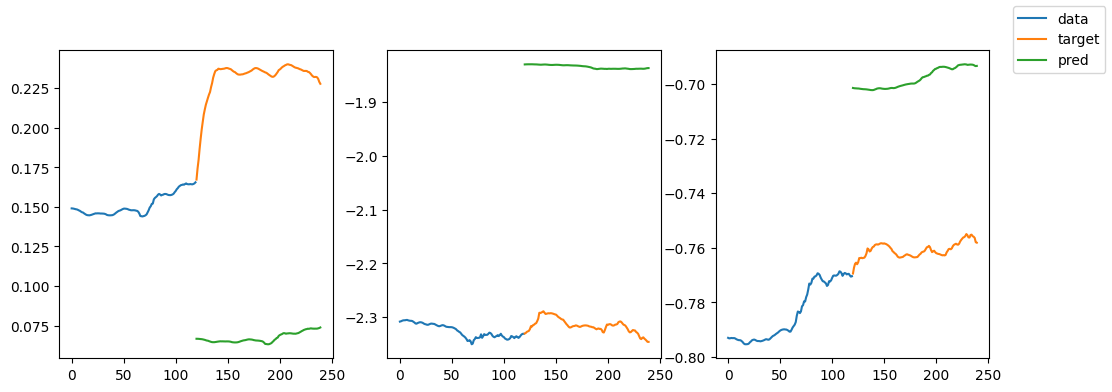

| epoch   1 |   222/  373 batches | lr 0.00500 | ms/batch 1287.84566 | loss 0.80937
training prediction


<Figure size 640x480 with 0 Axes>

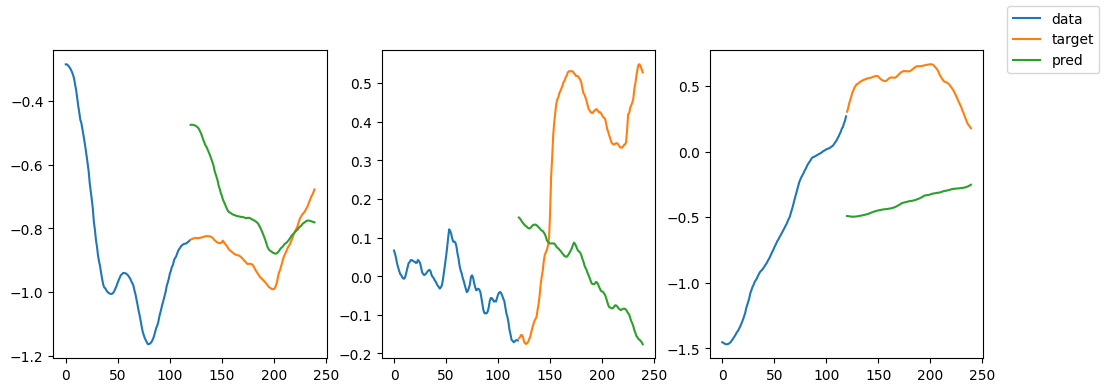

| epoch   1 |   296/  373 batches | lr 0.00500 | ms/batch 1158.07705 | loss 0.73905
training prediction


<Figure size 640x480 with 0 Axes>

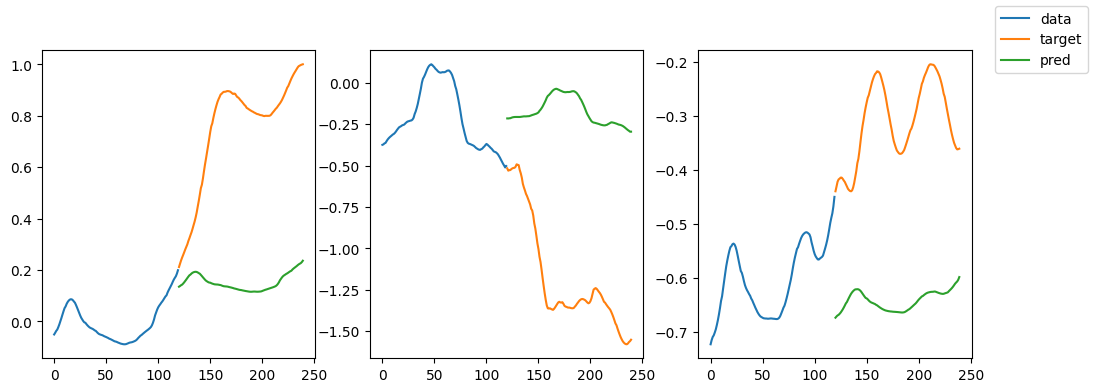

| epoch   1 |   370/  373 batches | lr 0.00500 | ms/batch 1144.60466 | loss 0.73179
training prediction


<Figure size 640x480 with 0 Axes>

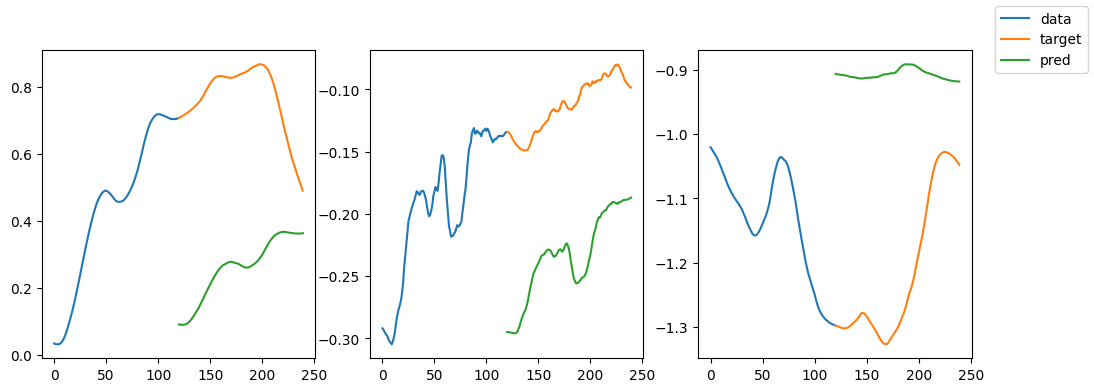

validation prediction


<Figure size 640x480 with 0 Axes>

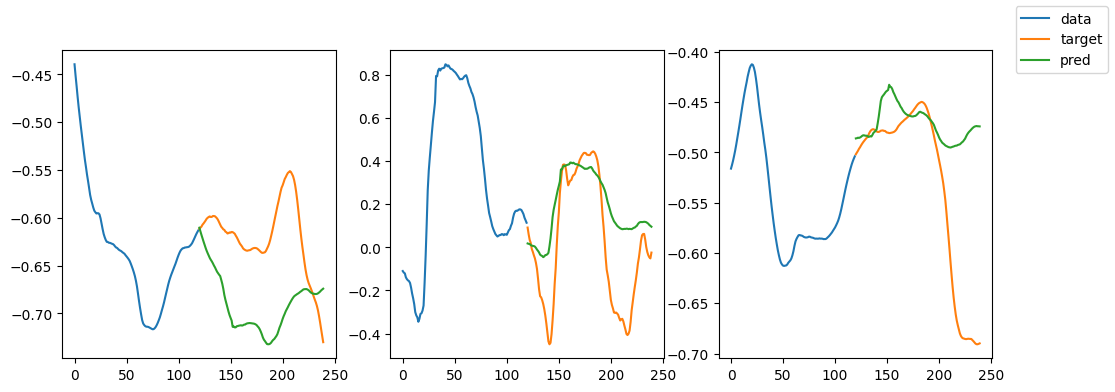

validation prediction


<Figure size 640x480 with 0 Axes>

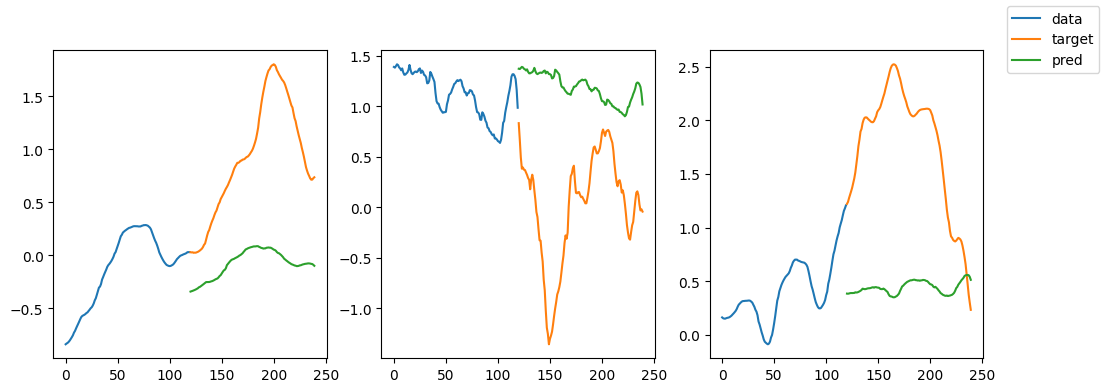

-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 490.82s | valid loss 1.5966 | mean loss   0.8741
-----------------------------------------------------------------------------------------


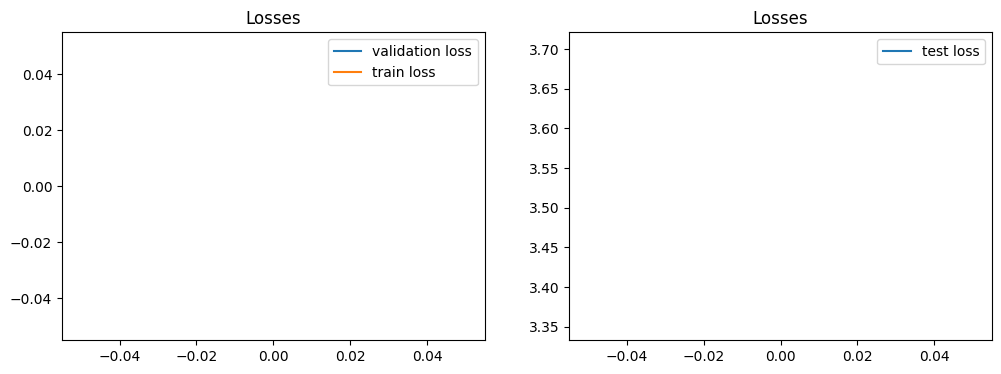

Epoch #2


  0%|          | 0/373 [00:00<?, ?it/s]

| epoch   2 |    74/  373 batches | lr 0.00475 | ms/batch 1168.63385 | loss 0.77225


In [19]:
# Trainig
#build live matplotlib fig


#plt.ion()
#fig.show()
#fig.canvas.draw()
epochs = 200
LOAD_MODEL = False
use_wandb = False
if LOAD_MODEL:
    load_ckpt(f"{PROJECT_PATH}/checkpoints/batch_{BATCH_SIZE}_{HISTORY_TIME}_{PREDICTION_TIME}_ckpts.pt".format(os.getcwd(), epochs, batch_size), model, optimizer)
lr = 0.1
# scaler = torch.cuda.amp.GradScaler()
# print(scaler)
best_val_loss = float('inf')
#writer = SummaryWriter("run/loss_plot")
step = 0
for epoch in tqdm(range(1, epochs+1)):
    print(f'Epoch #{epoch}')
    epoch_start_time = time.time()
    train_loss, sep_train_loss, train_pearsonr = train(DEVICE, model, train_dataloader, optimizer, step, feature_names, plot_flag=True if epoch % 2 == 1 else False)
#     print(train_loss)
    train_mse_losses.append(train_loss)
    sep_train_mse_losses.append(sep_train_loss)
    mean_loss = sum(train_mse_losses)/len(train_mse_losses)
    val_loss, sep_val_loss, val_pearsonr = validate(DEVICE, model, val_dataloader, feature_names, plot_flag=True if epoch % 2 == 1 else False)
    val_mse_losses.append(val_loss)
    sep_val_mse_losses.append(sep_val_loss)
    test_loss, sep_test_loss, test_pearsonr = validate(DEVICE, model, test_dataloader, feature_names, plot_flag=True if epoch % 2 == 1 else False)
    test_mse_losses.append(test_loss)
    sep_test_mse_losses.append(sep_test_loss)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
        f'valid loss {val_loss:5.4f} | mean loss {mean_loss:8.4f}')
    print('-' * 89)
    if epoch % 2 == 1:
        fig, ax = plt.subplots(1,2, figsize=(12,4))
        #ax.plot([i.detach().cpu().numpy() for i in test_losses], label='train loss')
        ax[0].plot([i.detach().cpu().numpy() for i in val_mse_losses[5:]] , label='validation loss')
        ax[0].plot([i  for i in train_mse_losses[5:]] , label='train loss')
        ax[0].set_title("Losses")

        ax[0].legend()
        ax[1].plot([i.detach().cpu().numpy() for i in test_mse_losses], label='test loss')
        ax[1].set_title("Losses")
        ax[1].legend()
        #fig.canvas.draw()
        plt.show()
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # save model
#         save_ckpt("{}/checkpoints/epoch_{}_ckpts.pt".format(os.getcwd(), epoch), model, optimizer,epochs, val_loss)
        save_dict = {
            'epoch': epoch,
            'train_mse_losses': train_mse_losses,
            'val_mse_losses': val_mse_losses
        }
        save_ckpt(f"{PROJECT_PATH}/checkpoints", model, optimizer, save_dict)

    # scheduler.step(mean_loss)
    scheduler.step()
# load_ckpt("/content/drive/MyDrive/checkpoints.pt", model, optimizer)


In [110]:
train_pearsonr, val_pearsonr, test_pearsonr

(PearsonRResult(statistic=0.8999170122893565, pvalue=0.0),
 PearsonRResult(statistic=-0.1753449540409303, pvalue=4.372262881678746e-36),
 PearsonRResult(statistic=-0.09360112869967743, pvalue=4.853049597576196e-07))

In [111]:
train_loss, val_loss, test_loss

(0.5273647349897083,
 tensor(1.8915, device='cuda:0'),
 tensor(3.7924, device='cuda:0'))

In [113]:
sep_train_loss, sep_val_loss, sep_test_loss

(array([[0.16461457, 0.15520567, 0.2075445 ]]),
 array([[0.35710525, 1.26801515, 0.26639888]]),
 array([[1.07967716, 1.61824495, 1.09448443]]))

In [109]:
mean_std

array([[-0.1753801 ,  1.5404513 , -0.07789762,  0.6476149 ,  0.1928104 ,
         0.6331828 ],
       [-0.57218325,  1.4946657 ,  0.10119341,  0.5768779 ,  0.04357762,
         0.7048865 ],
       [-0.32691124,  1.5339261 ,  0.16154999,  0.44393888,  0.03929263,
         0.39338547]], dtype=float32)

In [ ]:
-0.17538009,  1.54045129, -0.07789762,  0.64761491,  0.19281041, 0.6331828

In [31]:
load_ckpt(f"{PROJECT_PATH}/checkpoints/batch_{BATCH_SIZE}_{HISTORY_TIME}_{PREDICTION_TIME}_ckpts.pt".format(os.getcwd(), epochs, batch_size), model, optimizer)

(Transformer(
   (encs): ModuleList(
     (0-1): 2 x EncoderLayer(
       (attn): MultiHeadAttentionBlock(
         (heads): ModuleList(
           (0-2): 3 x AttentionBlock(
             (value): Linear(in_features=9, out_features=3, bias=True)
             (key): Linear(in_features=9, out_features=3, bias=True)
             (query): Linear(in_features=9, out_features=3, bias=True)
           )
         )
         (fc): Linear(in_features=9, out_features=9, bias=True)
       )
       (fc1): Linear(in_features=9, out_features=9, bias=True)
       (fc2): Linear(in_features=9, out_features=9, bias=True)
       (norm1): LayerNorm((9,), eps=1e-05, elementwise_affine=True)
       (norm2): LayerNorm((9,), eps=1e-05, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
   )
   (pos): PositionalEncoding()
   (enc_input_fc): Linear(in_features=3, out_features=9, bias=True)
   (dec_input_fc): Linear(in_features=3, out_features=9, bias=True)
   (out_fc): Linear(in_featu

<Figure size 640x480 with 0 Axes>

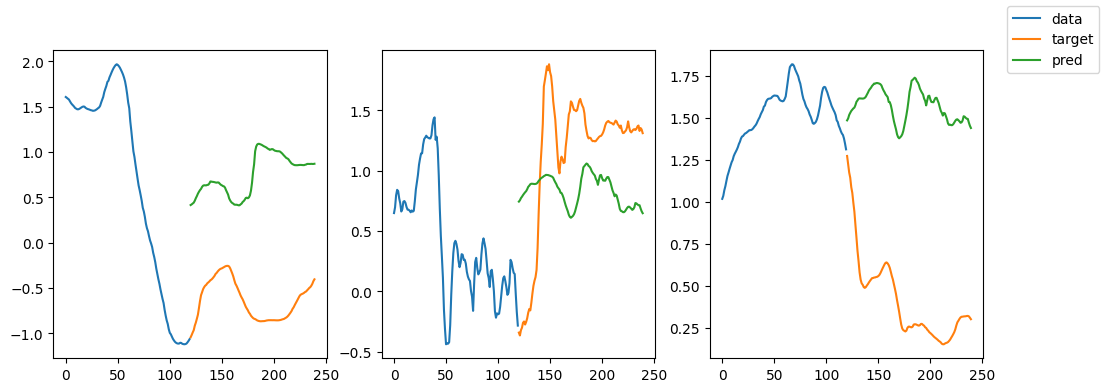

<Figure size 640x480 with 0 Axes>

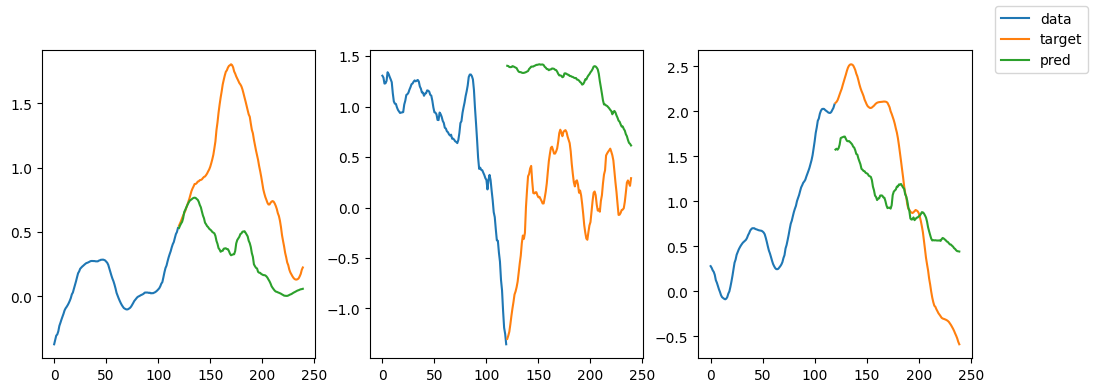

<Figure size 640x480 with 0 Axes>

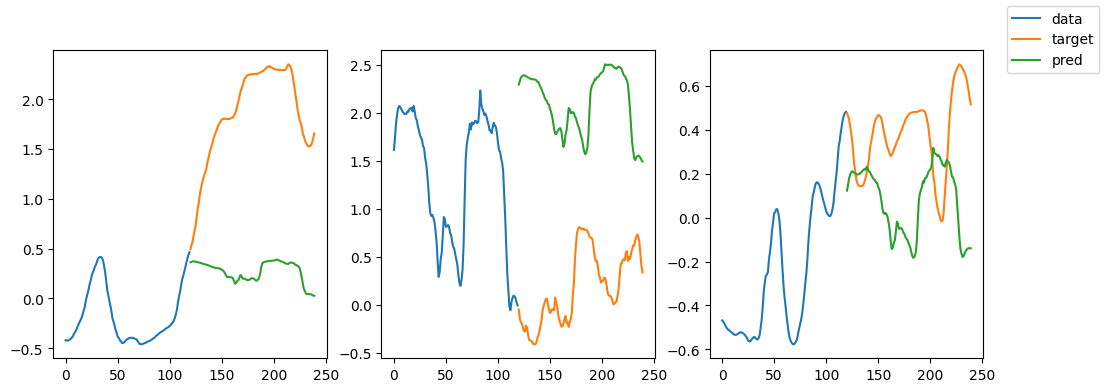

<Figure size 640x480 with 0 Axes>

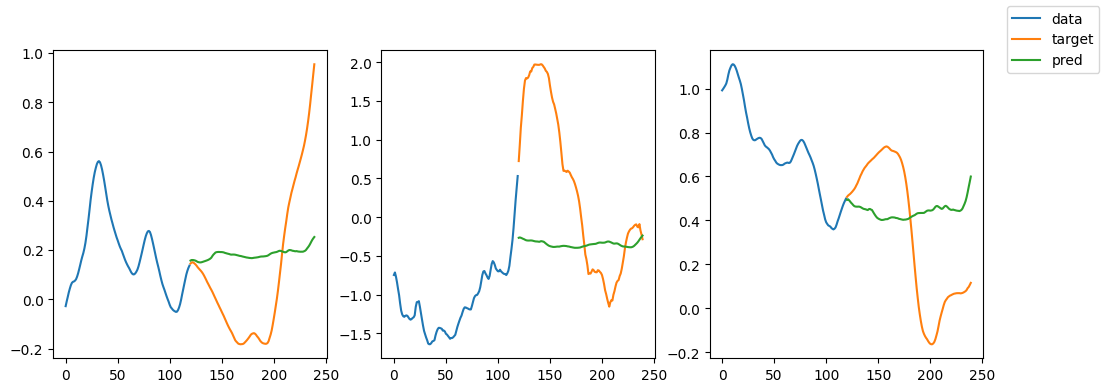

<Figure size 640x480 with 0 Axes>

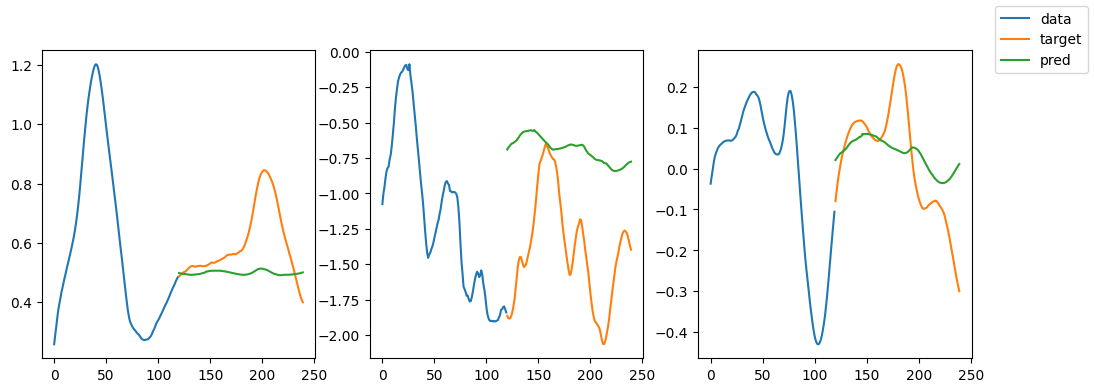

<Figure size 640x480 with 0 Axes>

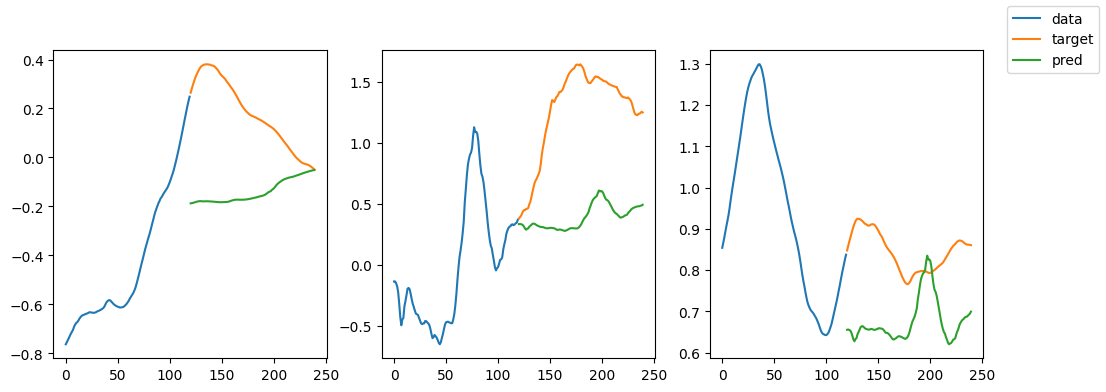

<Figure size 640x480 with 0 Axes>

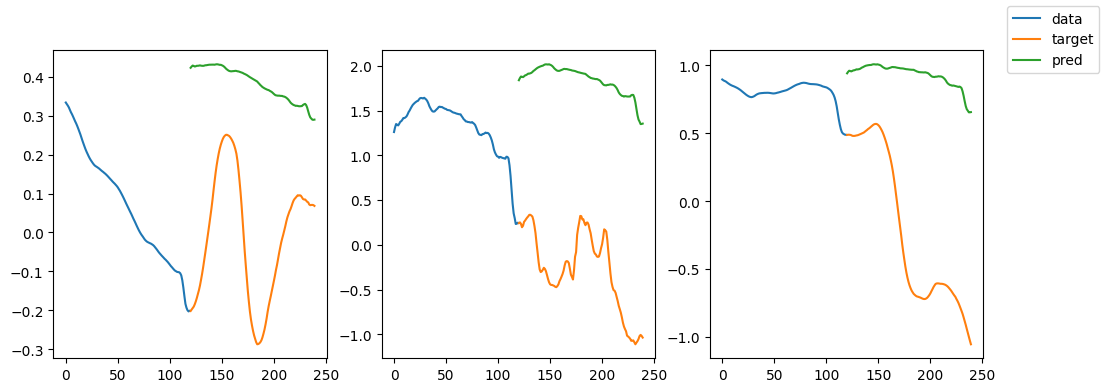

<Figure size 640x480 with 0 Axes>

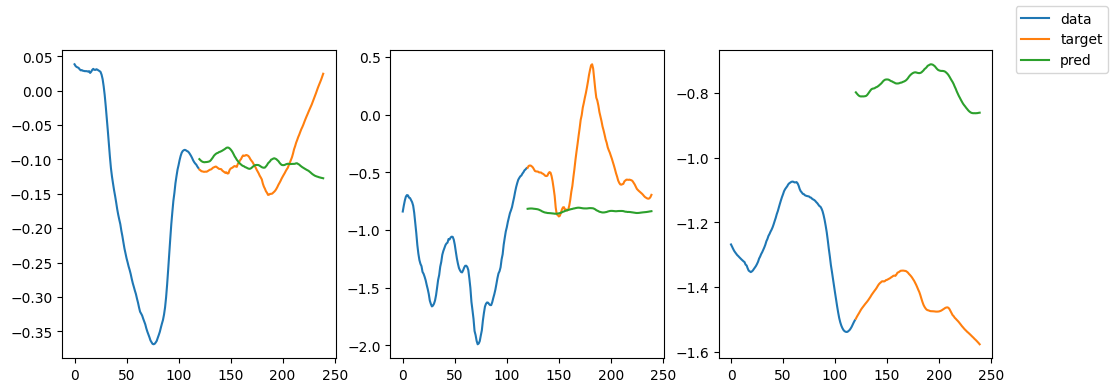

<Figure size 640x480 with 0 Axes>

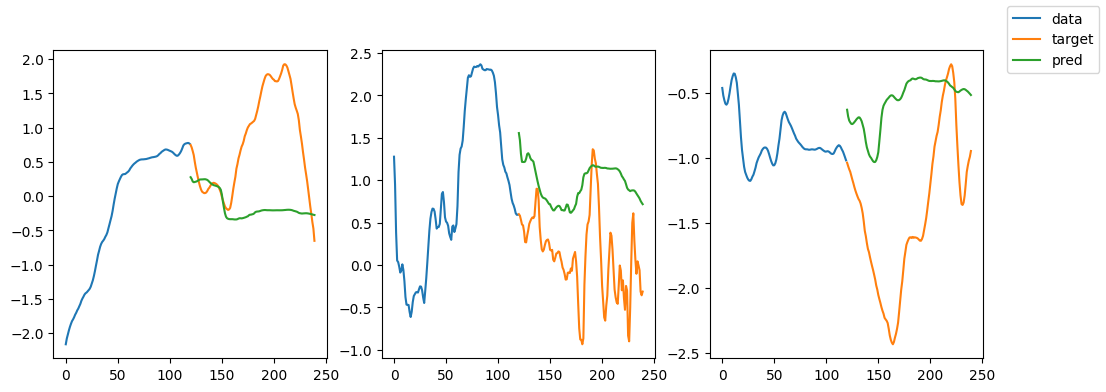

<Figure size 640x480 with 0 Axes>

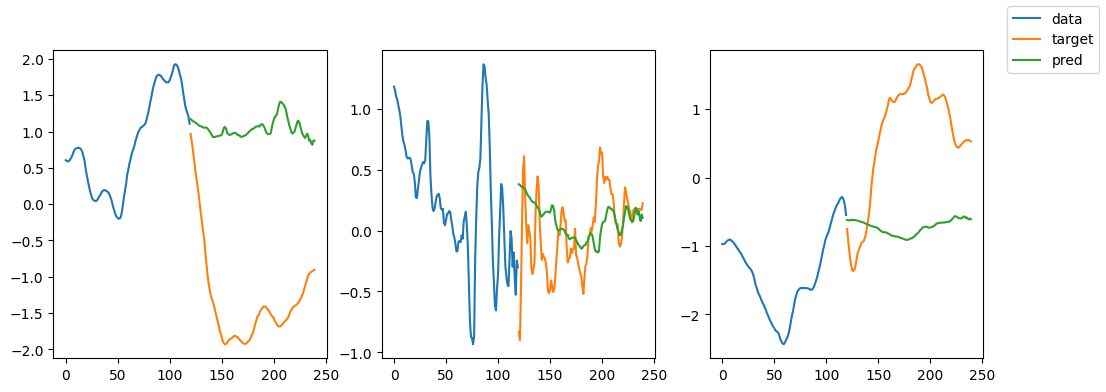

In [36]:
model.eval()
with torch.no_grad():
    for (data, targets) in test_dataloader:
        data = data.to(device=DEVICE) # [N, seq_len, feature_size]
        targets = targets.to(device=DEVICE) # [N, seq_len, feature_size]
        output = model(data)
        visualize_data(data.detach().cpu().numpy(), targets.detach().cpu().numpy(), output.detach().cpu().numpy())

In [33]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


__all__ = ['MultiHeadAttention', 'ScaledDotProductAttention']


class ScaledDotProductAttention(nn.Module):

    def forward(self, query, key, value, mask=None):
        dk = query.size()[-1]
        scores = query.matmul(key.transpose(-2, -1)) / math.sqrt(dk)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attention = F.softmax(scores, dim=-1)
        return attention.matmul(value)


class MultiHeadAttention(nn.Module):

    def __init__(self,
                 dim_val,
                 in_features,
                 head_num,
                 bias=True,
                 activation=F.leaky_relu):
        """Multi-head attention.

        :param in_features: Size of each input sample.
        :param head_num: Number of heads.
        :param bias: Whether to use the bias term.
        :param activation: The activation after each linear transformation.
        """
        super(MultiHeadAttention, self).__init__()
        if in_features % head_num != 0:
            raise ValueError('`in_features`({}) should be divisible by `head_num`({})'.format(in_features, head_num))
        self.in_features = in_features
        self.head_num = head_num
        self.activation = activation
        self.bias = bias
        self.linear_q = nn.Linear(in_features, in_features, bias)
        self.linear_k = nn.Linear(in_features, in_features, bias)
        self.linear_v = nn.Linear(in_features, in_features, bias)
        self.linear_o = nn.Linear(in_features, dim_val, bias)
        self.q = nn.Linear(dim_val, in_features, bias = False)
        self.k = nn.Linear(dim_val, in_features, bias = False)
        self.v = nn.Linear(dim_val, in_features, bias = False)
        #self.fc = nn.Linear(in_features * head_dim, dim_val, bias = False)
    def forward(self, x, mask=None):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        q, k, v = self.linear_q(q), self.linear_k(k), self.linear_v(v)
        if self.activation is not None:
            q = self.activation(q)
            k = self.activation(k)
            v = self.activation(v)

        q = self._reshape_to_batches(q)
        k = self._reshape_to_batches(k)
        v = self._reshape_to_batches(v)
        if mask is not None:
            mask = mask.repeat(self.head_num, 1, 1)
        y = ScaledDotProductAttention()(q, k, v, mask)
        y = self._reshape_from_batches(y)

        y = self.linear_o(y)
        if self.activation is not None:
            y = self.activation(y)
        #import pdb;pdb.set_trace()
        #y = self.fc(y)
        return y

    @staticmethod
    def gen_history_mask(x):
        """Generate the mask that only uses history data.

        :param x: Input tensor.
        :return: The mask.
        """
        batch_size, seq_len, _ = x.size()
        return torch.tril(torch.ones(seq_len, seq_len)).view(1, seq_len, seq_len).repeat(batch_size, 1, 1)

    def _reshape_to_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        sub_dim = in_feature // self.head_num
        return x.reshape(batch_size, seq_len, self.head_num, sub_dim)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size * self.head_num, seq_len, sub_dim)

    def _reshape_from_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        batch_size //= self.head_num
        out_dim = in_feature * self.head_num
        return x.reshape(batch_size, self.head_num, seq_len, in_feature)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size, seq_len, out_dim)

    def extra_repr(self):
        return 'in_features={}, head_num={}, bias={}, activation={}'.format(
            self.in_features, self.head_num, self.bias, self.activation,
        )

In [ ]:
# x: [N, enc_seq_len, dim_val]
a = self.attn(x)
x1 = self.norm1(x + a)
a1 = self.fc1(F.elu(self.fc2(x1)))
out = self.norm2(x1 + a1) # [N, enc_seq_len, dim_val]

In [ ]:
# MLP
mlp = self.enc_input_fc(x) # [N, enc_seq_len, dim_val]
#encoder
e = self.encs[0](self.pos(mlp))
for enc in self.encs[1:]:
    e = enc(e) # [N, enc_seq_len, dim_val]
#decoder
out = self.out_fc(e) # [N, enc_seq_len, feature_size]

In [ ]:
hist(mlp.detach().cpu().numpy().ravel())

In [ ]:
test_losses

In [ ]:
val_loss.cpu()